In [1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy
from scipy import sparse
from scipy.sparse import linalg as spla
from IPython.display import clear_output
import spectral



def plot_2D_field(xm, ym, data):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
   
    cmap_reversed = matplotlib.cm.get_cmap('RdBu_r')
    pcm = ax.pcolormesh(xm, ym, data,cmap=cmap_reversed,vmax=5,vmin=-5)
    plt.ylabel('y')
    plt.xlabel('x')
    ax.set_aspect(1)
    fig.colorbar(pcm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.tight_layout()

### Set initial conditions

In [2]:

N = 256
Len = 50
dt = 5e-3
epsilon = 1
g=1
rng = np.random.default_rng(seed=42)
INITIAL = (rng.random((N, N)))*0.3
total = 2000
gif = False


In [3]:




y_basis = spectral.Chebyshev(N,[0,Len])
x_basis = spectral.Fourier(N,[0,Len])

c = spectral.Field([x_basis, y_basis])
cy = spectral.Field([x_basis, y_basis])
c_RHS = spectral.Field([x_basis, y_basis])
cy_RHS = spectral.Field([x_basis, y_basis])
cyy = spectral.Field([x_basis, y_basis])
cyy_RHS = spectral.Field([x_basis, y_basis])
cyyy = spectral.Field([x_basis, y_basis])
cyyy_RHS = spectral.Field([x_basis, y_basis])
x = x_basis.grid()[:, None]

y = y_basis.grid()[None,:]
y = np.linspace(0,Len,N, endpoint=True)
xm, ym = np.meshgrid(x.ravel(), y.ravel())

alpha = 0.5*(y_basis.interval[-1] - y_basis.interval[0]) 



[0, 50]


In [4]:
problem = spectral.InitialValueProblem([c, cy,cyy,cyyy], [c_RHS, cy_RHS,cyy_RHS,cyyy_RHS], num_BCs=8)
diag = (np.arange(N-1)+1)/alpha 
D = sparse.diags(diag, offsets=1)

diag0 = np.ones(N)/2
diag0[0] = 1
diag2 = -np.ones(N-2)/2
C = sparse.diags((diag0, diag2), offsets=(0,2))

Z = sparse.csr_matrix((N, N))

In [5]:

for sp in problem.subproblems:
    n = sp.wavenumbers[0]
    
    sp.M = sparse.csr_matrix((8*N+8, 8*N+8))
    sp.M[6*N:7*N, :N] = C
    sp.M[7*N:8*N, N:2*N] = C
    sp.M.eliminate_zeros()
    
    L = sparse.bmat([[       D,        Z,   -C,    Z,   Z,  Z,  Z,  Z],
                     [       Z,        D,    Z,   -C,   Z,  Z,  Z,  Z],
                     [       Z,        Z,    D,   Z,   -C,  Z,  Z,  Z],
                     [       Z,        Z,    Z,   D,   Z,  -C,  Z,  Z],
                     [       Z,        Z,    Z,   Z,   D,  Z,  -C,  Z],
                     [       Z,        Z,    Z,   Z,   Z,  D,  Z,  -C],
                     [-C*2*n**2+C*n**4-(epsilon-1)*C,        Z, 2*D,   Z,-2*C*n**2,Z,D,Z],
                     [       Z, -C*2*n**2+C*n**4-(epsilon-1)*C,    Z,  2*D,Z,-C*2*n**2,Z,D]])
    
    i = np.arange(N)
    BC_rows = np.zeros((8, 8*N))
 
    BC_rows[0, :N] = (-1)**i
    BC_rows[1, :N] = (+1)**i
    BC_rows[2, N:2*N] = (-1)**i
    BC_rows[3, N:2*N] = (+1)**i
    BC_rows[4, 2*N:3*N] = (-1)**i
    BC_rows[5, 2*N:3*N] = (+1)**i
    BC_rows[6, 3*N:4*N] = (-1)**i
    BC_rows[7, 3*N:4*N] = (+1)**i
  
    
    cols = np.zeros((8*N,8))
    cols[  N-1, 0] = 1
    cols[2*N-1, 1] = 1
    cols[3*N-1, 2] = 1
    cols[4*N-1, 3] = 1
    cols[5*N-1, 4] = 1
    cols[6*N-1, 5] = 1
    cols[7*N-1, 6] = 1
    cols[8*N-1, 7] = 1

    
    
    corner = np.zeros((8,8))
    
    sp.L = sparse.bmat([[L, cols],
                        [BC_rows, corner]])
    
    sp.L.eliminate_zeros()

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


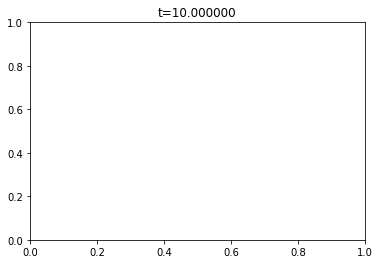

In [6]:
ts = spectral.SBDF2(problem)
c.require_grid_space()


c.data = INITIAL
c.require_grid_space()


if gif == True:
    ims = []
    fig = plt.figure(figsize=(10,10))
    cmap_reversed = matplotlib.cm.get_cmap('RdBu_r')
    ax = fig.subplots(1)

    



c.require_coeff_space()
cyyy_RHS.require_coeff_space()

BCs = np.array([0,0,0,0,0,0,0,0])

for i in range(total):
    c.require_grid_space(scales=2)
    cyyy_RHS.require_grid_space(scales=2)
        
    cyyy_RHS.data = g*c.data**2-c.data**3
    cyyy_RHS.require_coeff_space()
    cyyy_RHS.data = spectral.apply_matrix(C, cyyy_RHS.data, axis=1)

    ts.step(dt, BCs)
    

   

    c.require_grid_space()


    if gif==True:
        im = ax.imshow(c.data.T, animated=True,cmap=cmap_reversed)
        ims.append([im])
    
    else:

        title = plt.title('t=%f' %ts.time)
        plot_2D_field(xm,ym,c.data.T)
        title = plt.title('t=%f' %ts.time)
        plt.savefig('test'+str(i)+'.png')
        plt.close()

if gif == True:
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    writergif = animation.PillowWriter(fps=30)
    ani.save('filename.gif',writer=writergif)
    
        
   
        